## DQN sobre ambientes de Classic Control

https://gymnasium.farama.org/environments/classic_control/

### Imports

In [10]:
import torch
import numpy as np
import random
import numpy as np
import gymnasium

### Seteamos los devices

In [11]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Running on {DEVICE}")
print("Cuda Available:", torch.cuda.is_available())

Running on cpu
Cuda Available: False


### Seteo de seeds
Siempre es buena práctica hacer el seteo de seeds para la reproducibilidad de los experimentos

In [12]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True

### Creamos el ambiente y probamos algunas de sus funciones.

En este caso elegimos el CartPole pero pueden cambiarlo en la variable *ENV_NAME*.
El ambiente CartPole tiene la ventaja de que las recompensas son positivas y es mas fácil propagar estas hacia los estados iniciales. Mountain Car tiene como recompensa -1 por cada paso que damos y esta limitado a 200 pasos.

In [13]:
ENVS = ["MountainCar-v0", "CartPole-v1"]
ENV_NAME = ENVS[1]

env = gymnasium.make(ENV_NAME, render_mode="rgb_array")

print("Actions #",env.action_space)
print(env.observation_space.shape)
env.reset()
next_state, reward, terminated, truncated, info = env.step(action=0)

print(f"{next_state.shape},\n {reward},\n {terminated},\n {info}")

Actions # Discrete(2)
(4,)
(4,),
 1.0,
 False,
 {}


### Seteamos los hyperparámetros

In [14]:
def process_state(obs, device):
    return torch.tensor(obs, device=device).unsqueeze(0)

#Hiperparámetros de entrenamiento del agente DQN
TOTAL_STEPS = 1000000
EPISODES = 1000
STEPS = 200

EPSILON_INI = 1
EPSILON_MIN = 0.1
EPSILON_DECAY = .99999
EPISODE_BLOCK = 100
EPSILON_TIME = 100000

BATCH_SIZE = 2
BUFFER_SIZE = 3

GAMMA = 0.999
LEARNING_RATE = 1e-4

### Creamos el ambiente que vamos a estar usando para el entrenamiento

In [15]:
env = gymnasium.make(ENV_NAME)
input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n

print(f"Input dim: {input_dim}, Output dim: {output_dim}")

Input dim: 4, Output dim: 2


In [16]:
# from actor_critic_models import ActorModel, CriticModel
# from actor_critic_agent import ActorCriticAgent

# actor = ActorModel(input_dim, output_dim).to(DEVICE)
# critic = CriticModel(input_dim).to(DEVICE)

# agent = ActorCriticAgent(env, actor, process_state, BUFFER_SIZE, BATCH_SIZE, 
#                 LEARNING_RATE, GAMMA, epsilon_i= EPSILON_INI, 
#                 epsilon_f=EPSILON_MIN, epsilon_anneal_time=EPSILON_TIME,
#                 epsilon_decay = EPSILON_DECAY, episode_block = EPISODE_BLOCK, device=DEVICE, critic_model=critic)

In [17]:
from dqn_model import DQN_Model
from dqn_agent import DQNAgent
net = DQN_Model(input_dim, output_dim).to(DEVICE)

agent = DQNAgent(env, net, process_state, BUFFER_SIZE, BATCH_SIZE, 
                LEARNING_RATE, GAMMA, epsilon_i= EPSILON_INI, 
                epsilon_f=EPSILON_MIN, epsilon_anneal_time=EPSILON_TIME,
                epsilon_decay = EPSILON_DECAY, episode_block = EPISODE_BLOCK, device=DEVICE, second_model_update=50)

In [18]:
rewards = agent.train(EPISODES, STEPS, TOTAL_STEPS, writer_name = ENV_NAME)

  0%|          | 0/1000 [00:00<?, ? episodes/s]

States tensor([[-0.0497, -0.0368, -0.0233, -0.0012]]) -
Actions 0 -
Rewards tensor([1.]) -
Dones False -
Next states [-0.05047343 -0.23161155 -0.02331775  0.2840587 ] -
States tensor([[-0.0505, -0.2316, -0.0233,  0.2841]]) -
Actions 0 -
Rewards tensor([1.]) -
Dones False -
Next states [-0.05510566 -0.4263933  -0.01763657  0.5692971 ] -
States tensor([[-0.0551, -0.4264, -0.0176,  0.5693]]) -
Actions 1 -
Rewards tensor([1.]) -
Dones False -
Next states [-0.06363352 -0.23102848 -0.00625063  0.27111056] -
-----------------------------------------------
P0 tensor([[0.0216, 0.0035],
        [0.0224, 0.0045]], grad_fn=<AddmmBackward0>) - torch.Size([2, 2])
P1 tensor([0.0216, 0.0224]) - torch.Size([2])
P2 tensor([0.0216, 0.0224]) - torch.Size([2])
P3 tensor([0.0216, 0.0224]) - torch.Size([2])
P4 tensor([1.0216, 1.0224]) - torch.Size([2])
-----------------------------------------------
States tensor([[-0.0497, -0.0368, -0.0233, -0.0012],
        [-0.0551, -0.4264, -0.0176,  0.5693]]) - torch.Si

  0%|          | 1/1000 [00:00<03:47,  4.40 episodes/s]

States tensor([[ 0.0075,  0.1812, -0.1846, -0.8114]]) -
Actions 0 -
Rewards tensor([1.]) -
Dones False -
Next states [ 0.01113948 -0.01099619 -0.20084533 -0.5820484 ] -
-----------------------------------------------
P0 tensor([[ 0.0076, -0.0441],
        [ 0.0101, -0.0368]], grad_fn=<AddmmBackward0>) - torch.Size([2, 2])
P1 tensor([0.0076, 0.0101]) - torch.Size([2])
P2 tensor([0.0076, 0.0100]) - torch.Size([2])
P3 tensor([0.0076, 0.0100]) - torch.Size([2])
P4 tensor([1.0076, 1.0100]) - torch.Size([2])
-----------------------------------------------
States tensor([[ 0.0075,  0.1812, -0.1846, -0.8114],
        [ 0.0121, -0.2130, -0.1727, -0.1273]]) - torch.Size([2, 4])
Actions tensor([[0],
        [1]]) - torch.Size([2, 1])
Rewards tensor([1., 1.]) - torch.Size([2])
Dones tensor([0., 0.], dtype=torch.float16) - torch.Size([2])
Next states tensor([[ 0.0111, -0.0110, -0.2008, -0.5820],
        [ 0.0078, -0.0159, -0.1752, -0.4691]]) - torch.Size([2, 1, 4])
Next values tensor([1.0076, 1.010

  0%|          | 2/1000 [00:00<02:39,  6.24 episodes/s]

P0 tensor([[ 0.0093,  0.0105],
        [-0.0041,  0.0098]], grad_fn=<AddmmBackward0>) - torch.Size([2, 2])
P1 tensor([0.0105, 0.0098]) - torch.Size([2])
P2 tensor([0.0104, 0.0098]) - torch.Size([2])
P3 tensor([0.0104, 0.0098]) - torch.Size([2])
P4 tensor([1.0104, 1.0098]) - torch.Size([2])
-----------------------------------------------
States tensor([[-0.0764, -0.4014,  0.1709,  0.7983],
        [-0.0845, -0.2090,  0.1868,  0.5638]]) - torch.Size([2, 4])
Actions tensor([[1],
        [0]]) - torch.Size([2, 1])
Rewards tensor([1., 1.]) - torch.Size([2])
Dones tensor([0., 0.], dtype=torch.float16) - torch.Size([2])
Next states tensor([[-0.0845, -0.2090,  0.1868,  0.5638],
        [-0.0887, -0.4062,  0.1981,  0.9091]]) - torch.Size([2, 1, 4])
Next values tensor([1.0104, 1.0098]) - torch.Size([2])
Q-values tensor([[0.0817, 0.0941],
        [0.0948, 0.0925]], grad_fn=<AddmmBackward0>) - torch.Size([2, 2])
Q-values tensor([[0.0941],
        [0.0948]], grad_fn=<GatherBackward0>) - torch.Size(

  0%|          | 3/1000 [00:00<02:35,  6.43 episodes/s]

Q-values tensor([[0.1187, 0.1322],
        [0.1193, 0.1392]], grad_fn=<AddmmBackward0>) - torch.Size([2, 2])
Q-values tensor([[0.1187],
        [0.1392]], grad_fn=<GatherBackward0>) - torch.Size([2, 1])
States tensor([[-0.0836, -0.7662,  0.1672,  1.4012]]) -
Actions 1 -
Rewards tensor([1.]) -
Dones False -
Next states [-0.09889463 -0.5734595   0.1951817   1.1651312 ] -
-----------------------------------------------
P0 tensor([[-0.0169, -0.0207],
        [-0.0105, -0.0013]], grad_fn=<AddmmBackward0>) - torch.Size([2, 2])
P1 tensor([-0.0169, -0.0013]) - torch.Size([2])
P2 tensor([-0.0169, -0.0013]) - torch.Size([2])
P3 tensor([-0.0169, -0.0013]) - torch.Size([2])
P4 tensor([0.9831, 0.9987]) - torch.Size([2])
-----------------------------------------------
States tensor([[-0.0491, -0.7632,  0.1077,  1.3249],
        [-0.0836, -0.7662,  0.1672,  1.4012]]) - torch.Size([2, 4])
Actions tensor([[0],
        [1]]) - torch.Size([2, 1])
Rewards tensor([1., 1.]) - torch.Size([2])
Dones tensor([0

  0%|          | 4/1000 [00:00<02:31,  6.56 episodes/s]

Dones tensor([0., 1.], dtype=torch.float16) - torch.Size([2])
Next states tensor([[ 0.1737,  0.7746, -0.1845, -1.3471],
        [ 0.1892,  0.5822, -0.2114, -1.1174]]) - torch.Size([2, 1, 4])
Next values tensor([1.2376, 1.0000]) - torch.Size([2])
Q-values tensor([[0.2685, 0.2138],
        [0.3063, 0.2496]], grad_fn=<AddmmBackward0>) - torch.Size([2, 2])
Q-values tensor([[0.2138],
        [0.3063]], grad_fn=<GatherBackward0>) - torch.Size([2, 1])
States tensor([[0.0420, 0.0180, 0.0442, 0.0412]]) -
Actions 1 -
Rewards tensor([1.]) -
Dones False -
Next states [ 0.04240169  0.21246704  0.04499513 -0.23720357] -
-----------------------------------------------
P0 tensor([[0.2378, 0.1530],
        [0.2188, 0.1336]], grad_fn=<AddmmBackward0>) - torch.Size([2, 2])
P1 tensor([0.2378, 0.2188]) - torch.Size([2])
P2 tensor([0.2376, 0.2185]) - torch.Size([2])
P3 tensor([0.2376, 0.0000]) - torch.Size([2])
P4 tensor([1.2376, 1.0000]) - torch.Size([2])
-----------------------------------------------
Sta

  0%|          | 5/1000 [00:00<02:26,  6.77 episodes/s]

-----------------------------------------------
P0 tensor([[0.1357, 0.1327],
        [0.1264, 0.1417]], grad_fn=<AddmmBackward0>) - torch.Size([2, 2])
P1 tensor([0.1357, 0.1417]) - torch.Size([2])
P2 tensor([0.1356, 0.1416]) - torch.Size([2])
P3 tensor([0.1356, 0.1416]) - torch.Size([2])
P4 tensor([1.1356, 1.1416]) - torch.Size([2])
-----------------------------------------------
States tensor([[-0.0247, -0.3826,  0.1770,  0.8665],
        [-0.0323, -0.1902,  0.1943,  0.6343]]) - torch.Size([2, 4])
Actions tensor([[1],
        [0]]) - torch.Size([2, 1])
Rewards tensor([1., 1.]) - torch.Size([2])
Dones tensor([0., 0.], dtype=torch.float16) - torch.Size([2])
Next states tensor([[-0.0323, -0.1902,  0.1943,  0.6343],
        [-0.0361, -0.3875,  0.2070,  0.9813]]) - torch.Size([2, 1, 4])
Next values tensor([1.1356, 1.1416]) - torch.Size([2])
Q-values tensor([[0.1936, 0.2117],
        [0.2018, 0.2033]], grad_fn=<AddmmBackward0>) - torch.Size([2, 2])
Q-values tensor([[0.2117],
        [0.2018

  1%|          | 6/1000 [00:00<02:42,  6.10 episodes/s]

States tensor([[-0.0102, -0.3488, -0.0500,  0.3334]]) -
Actions 1 -
Rewards tensor([1.]) -
Dones False -
Next states [-0.01713181 -0.15302029 -0.04334923  0.0254144 ] -
-----------------------------------------------
P0 tensor([[0.1552, 0.1278],
        [0.1398, 0.1361]], grad_fn=<AddmmBackward0>) - torch.Size([2, 2])
P1 tensor([0.1552, 0.1398]) - torch.Size([2])
P2 tensor([0.1550, 0.1397]) - torch.Size([2])
P3 tensor([0.1550, 0.1397]) - torch.Size([2])
P4 tensor([1.1550, 1.1397]) - torch.Size([2])
-----------------------------------------------
States tensor([[ 0.0007, -0.5448, -0.0629,  0.6453],
        [ 0.0078, -0.3507, -0.0704,  0.3756]]) - torch.Size([2, 4])
Actions tensor([[1],
        [0]]) - torch.Size([2, 1])
Rewards tensor([1., 1.]) - torch.Size([2])
Dones tensor([0., 0.], dtype=torch.float16) - torch.Size([2])
Next states tensor([[-0.0102, -0.3488, -0.0500,  0.3334],
        [ 0.0007, -0.5448, -0.0629,  0.6453]]) - torch.Size([2, 1, 4])
Next values tensor([1.1550, 1.1397]) 

  1%|          | 7/1000 [00:01<02:34,  6.42 episodes/s]

States tensor([[ 0.2046,  1.0152, -0.1570, -1.4977]]) -
Actions 1 -
Rewards tensor([1.]) -
Dones False -
Next states [ 0.22487335  1.2118498  -0.18699375 -1.8350445 ] -
-----------------------------------------------
P0 tensor([[0.4591, 0.3785],
        [0.5804, 0.4843]], grad_fn=<AddmmBackward0>) - torch.Size([2, 2])
P1 tensor([0.4591, 0.5804]) - torch.Size([2])
P2 tensor([0.4587, 0.5799]) - torch.Size([2])
P3 tensor([0.4587, 0.5799]) - torch.Size([2])
P4 tensor([1.4587, 1.5799]) - torch.Size([2])
-----------------------------------------------
States tensor([[ 0.1680,  1.0123, -0.1052, -1.4243],
        [ 0.2046,  1.0152, -0.1570, -1.4977]]) - torch.Size([2, 4])
Actions tensor([[0],
        [1]]) - torch.Size([2, 1])
Rewards tensor([1., 1.]) - torch.Size([2])
Dones tensor([0., 0.], dtype=torch.float16) - torch.Size([2])
Next states tensor([[ 0.1882,  0.8186, -0.1337, -1.1663],
        [ 0.2249,  1.2118, -0.1870, -1.8350]]) - torch.Size([2, 1, 4])
Next values tensor([1.4587, 1.5799]) 

  1%|          | 8/1000 [00:01<02:46,  5.96 episodes/s]

P1 tensor([0.3542, 0.3843]) - torch.Size([2])
P2 tensor([0.3538, 0.3840]) - torch.Size([2])
P3 tensor([0.3538, 0.3840]) - torch.Size([2])
P4 tensor([1.3538, 1.3840]) - torch.Size([2])
-----------------------------------------------
States tensor([[ 0.0582,  0.2128, -0.1469, -0.5738],
        [ 0.0579,  0.0159, -0.1421, -0.2399]]) - torch.Size([2, 4])
Actions tensor([[0],
        [1]]) - torch.Size([2, 1])
Rewards tensor([1., 1.]) - torch.Size([2])
Dones tensor([0., 0.], dtype=torch.float16) - torch.Size([2])
Next states tensor([[ 0.0625,  0.0200, -0.1583, -0.3308],
        [ 0.0582,  0.2128, -0.1469, -0.5738]]) - torch.Size([2, 1, 4])
Next values tensor([1.3538, 1.3840]) - torch.Size([2])
Q-values tensor([[0.4878, 0.4874],
        [0.4201, 0.4312]], grad_fn=<AddmmBackward0>) - torch.Size([2, 2])
Q-values tensor([[0.4878],
        [0.4312]], grad_fn=<GatherBackward0>) - torch.Size([2, 1])
States tensor([[ 0.0629, -0.1726, -0.1650, -0.0919]]) -
Actions 1 -
Rewards tensor([1.]) -
Dones Fa

  1%|          | 9/1000 [00:01<03:30,  4.70 episodes/s]

-----------------------------------------------
P0 tensor([[0.4631, 0.4823],
        [0.4066, 0.4455]], grad_fn=<AddmmBackward0>) - torch.Size([2, 2])
P1 tensor([0.4823, 0.4455]) - torch.Size([2])
P2 tensor([0.4818, 0.4451]) - torch.Size([2])
P3 tensor([0.4818, 0.4451]) - torch.Size([2])
P4 tensor([1.4818, 1.4451]) - torch.Size([2])
-----------------------------------------------
States tensor([[ 0.0084,  0.5972,  0.2071, -0.2437],
        [ 0.0204,  0.3998,  0.2022,  0.1065]]) - torch.Size([2, 4])
Actions tensor([[0],
        [0]]) - torch.Size([2, 1])
Rewards tensor([1., 1.]) - torch.Size([2])
Dones tensor([0., 0.], dtype=torch.float16) - torch.Size([2])
Next states tensor([[0.0204, 0.3998, 0.2022, 0.1065],
        [0.0284, 0.2025, 0.2043, 0.4556]]) - torch.Size([2, 1, 4])
Next values tensor([1.4818, 1.4451]) - torch.Size([2])
Q-values tensor([[0.6168, 0.6187],
        [0.5420, 0.5634]], grad_fn=<AddmmBackward0>) - torch.Size([2, 2])
Q-values tensor([[0.6168],
        [0.5420]], grad

  1%|          | 11/1000 [00:01<02:40,  6.17 episodes/s]

States tensor([[ 0.0777,  0.5954, -0.1529, -1.0759]]) -
Actions 0 -
Rewards tensor([1.]) -
Dones False -
Next states [ 0.08961477  0.4025476  -0.17437385 -0.8348417 ] -
-----------------------------------------------
P0 tensor([[0.6338, 0.6303],
        [0.6132, 0.6083]], grad_fn=<AddmmBackward0>) - torch.Size([2, 2])
P1 tensor([0.6338, 0.6132]) - torch.Size([2])
P2 tensor([0.6332, 0.6126]) - torch.Size([2])
P3 tensor([0.6332, 0.6126]) - torch.Size([2])
P4 tensor([1.6332, 1.6126]) - torch.Size([2])
-----------------------------------------------
States tensor([[ 0.0777,  0.5954, -0.1529, -1.0759],
        [ 0.0657,  0.2019, -0.1297, -0.4126]]) - torch.Size([2, 4])
Actions tensor([[0],
        [1]]) - torch.Size([2, 1])
Rewards tensor([1., 1.]) - torch.Size([2])
Dones tensor([0., 0.], dtype=torch.float16) - torch.Size([2])
Next states tensor([[ 0.0896,  0.4025, -0.1744, -0.8348],
        [ 0.0697,  0.3986, -0.1380, -0.7432]]) - torch.Size([2, 1, 4])
Next values tensor([1.6332, 1.6126]) 

  1%|          | 12/1000 [00:01<02:27,  6.71 episodes/s]

Next values tensor([1.6434, 1.6623]) - torch.Size([2])
Q-values tensor([[0.5775, 0.7036],
        [0.6102, 0.7355]], grad_fn=<AddmmBackward0>) - torch.Size([2, 2])
Q-values tensor([[0.7036],
        [0.7355]], grad_fn=<GatherBackward0>) - torch.Size([2, 1])
States tensor([[-0.1319, -0.4360,  0.1971,  0.9026]]) -
Actions 0 -
Rewards tensor([1.]) -
Dones True -
Next states [-0.14062287 -0.6331698   0.21511509  1.2501991 ] -
-----------------------------------------------
P0 tensor([[0.5114, 0.6708],
        [0.4960, 0.6441]], grad_fn=<AddmmBackward0>) - torch.Size([2, 2])
P1 tensor([0.6708, 0.6441]) - torch.Size([2])
P2 tensor([0.6702, 0.6434]) - torch.Size([2])
P3 tensor([0.0000, 0.6434]) - torch.Size([2])
P4 tensor([1.0000, 1.6434]) - torch.Size([2])
-----------------------------------------------
States tensor([[-0.1319, -0.4360,  0.1971,  0.9026],
        [-0.1193, -0.6285,  0.1743,  1.1359]]) - torch.Size([2, 4])
Actions tensor([[0],
        [1]]) - torch.Size([2, 1])
Rewards tensor

  1%|▏         | 13/1000 [00:02<02:35,  6.34 episodes/s]

Q-values tensor([[0.6157, 0.7204],
        [0.7153, 0.7385]], grad_fn=<AddmmBackward0>) - torch.Size([2, 2])
Q-values tensor([[0.6157],
        [0.7153]], grad_fn=<GatherBackward0>) - torch.Size([2, 1])
States tensor([[-0.0440, -0.6304,  0.0367,  0.9596]]) -
Actions 0 -
Rewards tensor([1.]) -
Dones False -
Next states [-0.05663511 -0.82604474  0.05588843  1.2636142 ] -
-----------------------------------------------
P0 tensor([[0.5274, 0.6756],
        [0.5004, 0.6397]], grad_fn=<AddmmBackward0>) - torch.Size([2, 2])
P1 tensor([0.6756, 0.6397]) - torch.Size([2])
P2 tensor([0.6749, 0.6390]) - torch.Size([2])
P3 tensor([0.6749, 0.6390]) - torch.Size([2])
P4 tensor([1.6749, 1.6390]) - torch.Size([2])
-----------------------------------------------
States tensor([[-0.0440, -0.6304,  0.0367,  0.9596],
        [-0.0353, -0.4350,  0.0235,  0.6596]]) - torch.Size([2, 4])
Actions tensor([[0],
        [0]]) - torch.Size([2, 1])
Rewards tensor([1., 1.]) - torch.Size([2])
Dones tensor([0., 0.], dt

  1%|▏         | 14/1000 [00:02<02:41,  6.11 episodes/s]

Q-values tensor([[0.9567, 0.9431],
        [0.9906, 0.9709]], grad_fn=<AddmmBackward0>) - torch.Size([2, 2])
Q-values tensor([[0.9567],
        [0.9709]], grad_fn=<GatherBackward0>) - torch.Size([2, 1])
States tensor([[ 0.0072,  0.2018, -0.1422, -0.7099]]) -
Actions 0 -
Rewards tensor([1.]) -
Dones False -
Next states [ 0.01127247  0.00889406 -0.15643251 -0.46514294] -
-----------------------------------------------
P0 tensor([[0.9665, 0.9626],
        [1.0013, 0.9906]], grad_fn=<AddmmBackward0>) - torch.Size([2, 2])
P1 tensor([0.9665, 1.0013]) - torch.Size([2])
P2 tensor([0.9655, 1.0003]) - torch.Size([2])
P3 tensor([0.9655, 1.0003]) - torch.Size([2])
P4 tensor([1.9655, 2.0003]) - torch.Size([2])
-----------------------------------------------
States tensor([[ 0.0110, -0.1917, -0.1338, -0.0462],
        [ 0.0072,  0.2018, -0.1422, -0.7099]]) - torch.Size([2, 4])
Actions tensor([[1],
        [0]]) - torch.Size([2, 1])
Rewards tensor([1., 1.]) - torch.Size([2])
Dones tensor([0., 0.], dt

  2%|▏         | 15/1000 [00:02<03:06,  5.28 episodes/s]

States tensor([[ 0.1669,  1.1409, -0.1332, -1.4949]]) -
Actions 0 -
Rewards tensor([1.]) -
Dones False -
Next states [ 0.18969117  0.9475987  -0.16312352 -1.2465626 ] -
-----------------------------------------------
P0 tensor([[1.5678, 1.4517],
        [1.3813, 1.2878]], grad_fn=<AddmmBackward0>) - torch.Size([2, 2])
P1 tensor([1.5678, 1.3813]) - torch.Size([2])
P2 tensor([1.5662, 1.3799]) - torch.Size([2])
P3 tensor([1.5662, 1.3799]) - torch.Size([2])
P4 tensor([2.5662, 2.3799]) - torch.Size([2])
-----------------------------------------------
States tensor([[ 0.1480,  0.9445, -0.1098, -1.1699],
        [ 0.1252,  1.1385, -0.0811, -1.4361]]) - torch.Size([2, 4])
Actions tensor([[1],
        [0]]) - torch.Size([2, 1])
Rewards tensor([1., 1.]) - torch.Size([2])
Dones tensor([0., 0.], dtype=torch.float16) - torch.Size([2])
Next states tensor([[ 0.1669,  1.1409, -0.1332, -1.4949],
        [ 0.1480,  0.9445, -0.1098, -1.1699]]) - torch.Size([2, 1, 4])
Next values tensor([2.5662, 2.3799]) 

  2%|▏         | 16/1000 [00:02<03:10,  5.17 episodes/s]

Rewards tensor([1., 1.]) - torch.Size([2])
Dones tensor([0., 0.], dtype=torch.float16) - torch.Size([2])
Next states tensor([[ 0.0754,  0.7667, -0.1270, -1.1337],
        [ 0.0640,  0.5702, -0.1109, -0.8083]]) - torch.Size([2, 1, 4])
Next values tensor([2.7295, 2.5109]) - torch.Size([2])
Q-values tensor([[1.6116, 1.5717],
        [1.3906, 1.3962]], grad_fn=<AddmmBackward0>) - torch.Size([2, 2])
Q-values tensor([[1.5717],
        [1.3962]], grad_fn=<GatherBackward0>) - torch.Size([2, 1])
States tensor([[ 0.0754,  0.7667, -0.1270, -1.1337]]) -
Actions 1 -
Rewards tensor([1.]) -
Dones False -
Next states [ 0.09072059  0.96321225 -0.14970459 -1.4633418 ] -
-----------------------------------------------
P0 tensor([[1.9740, 1.8130],
        [1.7312, 1.6067]], grad_fn=<AddmmBackward0>) - torch.Size([2, 2])
P1 tensor([1.9740, 1.7312]) - torch.Size([2])
P2 tensor([1.9720, 1.7295]) - torch.Size([2])
P3 tensor([1.9720, 1.7295]) - torch.Size([2])
P4 tensor([2.9720, 2.7295]) - torch.Size([2])
----

  2%|▏         | 18/1000 [00:02<02:42,  6.05 episodes/s]

Rewards tensor([1.]) -
Dones False -
Next states [-0.08295485 -0.9439217   0.19412678  1.782246  ] -
-----------------------------------------------
P0 tensor([[1.0323, 1.2142],
        [0.9620, 1.1320]], grad_fn=<AddmmBackward0>) - torch.Size([2, 2])
P1 tensor([1.2142, 1.1320]) - torch.Size([2])
P2 tensor([1.2130, 1.1308]) - torch.Size([2])
P3 tensor([1.2130, 1.1308]) - torch.Size([2])
P4 tensor([2.2130, 2.1308]) - torch.Size([2])
-----------------------------------------------
States tensor([[-0.0570, -0.5505,  0.1431,  1.1089],
        [-0.0499, -0.3539,  0.1275,  0.7789]]) - torch.Size([2, 4])
Actions tensor([[0],
        [0]]) - torch.Size([2, 1])
Rewards tensor([1., 1.]) - torch.Size([2])
Dones tensor([0., 0.], dtype=torch.float16) - torch.Size([2])
Next states tensor([[-0.0680, -0.7472,  0.1653,  1.4428],
        [-0.0570, -0.5505,  0.1431,  1.1089]]) - torch.Size([2, 1, 4])
Next values tensor([2.2130, 2.1308]) - torch.Size([2])
Q-values tensor([[1.1581, 1.3875],
        [1.1116

KeyboardInterrupt: 

### Graficamos las recompensas obtenidas durante el entrenamiento 

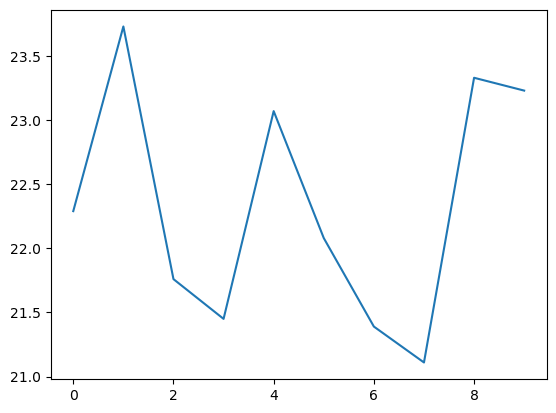

In [ ]:
import matplotlib.pyplot as plt

average_range = EPISODE_BLOCK
episode_ticks = int(len(rewards) / average_range)

avg_rewards = np.array(rewards).reshape((episode_ticks, average_range))
avg_rewards = np.mean(avg_rewards, axis=1)

plt.plot(range(len(avg_rewards)), avg_rewards)

### Creamos un video para ver la performance del agente

In [ ]:
import glob
from gymnasium.wrappers.record_video import RecordVideo
from IPython.display import HTML
from IPython import display as ipythondisplay
import io
import base64

def show_video():
  """
  Utility function to enable video recording of gym environment and displaying it
  To enable video, just do "env = wrap_env(env)""
  """
  mp4list = glob.glob('./videos/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")


def wrap_env(env):
  """
  Wrapper del ambiente donde definimos un Monitor que guarda la visualizacion como un archivo de video.
  """

  #env = Monitor(env, './video', force=True)
  env = RecordVideo(env,video_folder='./videos')
  return env

In [ ]:
env = wrap_env(gymnasium.make(ENV_NAME, render_mode="rgb_array"))
observation,_ = env.reset()

while True:
    env.render()

    action = agent.select_action(process_state(observation, DEVICE), train=False)
    observation, reward, done, truncated, _ = env.step(action.item())

    if done or truncated:
      break

# Cerramos la conexion con el Monitor de ambiente y mostramos el video.
env.close()
show_video()

del env

c:\Users\juan1\anaconda3\envs\TallerIA\lib\site-packages\gymnasium\wrappers\record_video.py:94: UserWarning: WARN: Overwriting existing videos at c:\Users\juan1\Ort\Agentes Inteligentes\reinforcement-learning\Atari\videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


DependencyNotInstalled: moviepy is not installed, run `pip install moviepy`